In [1]:
# utils
import warnings

# data processing and handling pkgs
import pandas as pd
import numpy as np
from astral import LocationInfo
from astral.sun import sun


# plotting packages
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go

# NN modelling packages
import keras


# custom methods
from custom_utils import *

# global settings
np.random.seed(27)
warnings.filterwarnings("ignore")

In [2]:
data_path = "./../data/"
file_name = "data.csv"
data = pd.read_csv(data_path + file_name)
data = first_preprocess(data, data_path)
data.head()

,space_heating,hot_water,sockets,lighting,bld_engcons,car_chargers,weekend,bank_holiday,day_of_week,day_of_month,...,forecast_weathertype,forecast_windspeed,forecast_uvindex,forecast_precipitationprobability,forecast_visibility,week_of_year,sine_hour,cos_hour,sine_forecast_winddirection,cos_forecast_winddirection
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,3.425193,0.000000,0.049433,0.154873,3.629499,0.0,0,1,5,1,...,2.0,11.0,0.0,0.0,5,53,0.000000,1.000000,0.000000,1.00000
2021-01-01 01:00:00+00:00,4.012907,0.000000,0.047753,0.154846,4.215506,0.0,0,1,5,1,...,2.0,11.0,0.0,0.0,5,53,0.258819,0.965926,0.000000,1.00000
2021-01-01 02:00:00+00:00,5.342417,0.444782,0.051869,0.154997,5.994066,0.0,0,1,5,1,...,2.0,11.0,0.0,1.0,5,53,0.500000,0.866025,0.000000,1.00000
2021-01-01 03:00:00+00:00,5.756598,0.000000,0.043028,0.154626,5.954252,0.0,0,1,5,1,...,0.0,11.0,0.0,1.0,5,53,0.707107,0.707107,-0.382683,0.92388
2021-01-01 04:00:00+00:00,5.415492,0.000000,0.050306,0.154498,5.620296,0.0,0,1,5,1,...,0.0,11.0,0.0,1.0,5,53,0.866025,0.500000,-0.382683,0.92388


In [3]:
data.shape

(26280, 24)

In [5]:
from datetime import timedelta, datetime

In [52]:
from sklearn.linear_model import LinearRegression

In [53]:
model = LinearRegression(n_jobs=-1)

In [55]:
drop_columns = ['space_heating', 'hot_water', 'sockets', 'lighting', 'car_chargers']
main_data = data.drop(columns=drop_columns)
main_data["t-1"] = main_data["bld_engcons"].shift(-1)

In [57]:
main_data["t-1"] = main_data["t-1"].interpolate(method="linear", limit_direction="both")

In [59]:
x_cols = ['weekend', 'bank_holiday', 'day_of_week', 'day_of_month',
       'month', 'year', 'forecast_temperature', 'forecast_feelslike',
       'forecast_weathertype', 'forecast_windspeed', 'forecast_uvindex',
       'forecast_precipitationprobability', 'forecast_visibility',
       'week_of_year', 'sine_hour', 'cos_hour', 'sine_forecast_winddirection',
       'cos_forecast_winddirection', 't-1']
y_cols = ["bld_engcons"]

In [111]:
from tqdm.notebook import tqdm

In [151]:
def sliding_window_validation(
        start_date="01-01-2023 00:00:00", 
        end_date="01-01-2024 00:00:00",
        window_size=14, 
        model=None, 
        data=None, 
        x_cols=None, 
        y_col=None
    ):
    all_dates = []
    validation_metrics = pd.DataFrame()

    # training window
    t_start_date = datetime.strptime(start_date, '%d-%m-%Y %H:%M:%S').date()
    t_end_date = t_start_date + timedelta(days=window_size)
    # validation window
    v_start_date = t_end_date
    v_end_date = v_start_date + timedelta(days=window_size)

    max_date = datetime.strptime(end_date, '%d-%m-%Y %H:%M:%S').date()
    no_data = []
    progress_bar = tqdm(total=(((max_date - t_start_date).days // 7) // 2) - 1)
    while v_end_date <= max_date: # validation window will be the first to reach the end date

        # check if the last date with max date
        if v_end_date + timedelta(days=window_size) > max_date:
            v_end_date = max_date
        
        # filter data
        train_data = data[(data.index >= t_start_date.strftime("%Y-%m-%d")) & 
                          (data.index < v_start_date.strftime("%Y-%m-%d"))]
        val_data = data[(data.index >= v_start_date.strftime("%Y-%m-%d")) & 
                        (data.index < v_end_date.strftime("%Y-%m-%d"))]
        if train_data.shape[0] != 0 and val_data.shape[0] != 0:
            model = model.fit(train_data[x_cols], train_data[y_col])
            predictions = pd.DataFrame({"pred": model.predict(val_data[x_cols]).reshape(-1).tolist()})

            metrics_df = cal_metrics(val_data[y_col].to_numpy(), predictions["pred"].to_numpy())
            metrics_df["start_date"] = v_start_date
            metrics_df["end_date"] = v_end_date
            validation_metrics = pd.concat([validation_metrics, metrics_df], axis=0, ignore_index=True)
            
        else:
            no_data.append((v_start_date, v_end_date))

        # update the dates
        t_start_date = v_start_date
        t_end_date = v_end_date
        v_start_date = t_end_date
        v_end_date = v_start_date + timedelta(days=window_size)
        progress_bar.update(1)
    
    progress_bar.close()
    
    return model, validation_metrics, no_data

In [152]:
model, validation_metrics, no_data = sliding_window_validation(
    start_date="01-01-2023 00:00:00", 
    end_date="01-01-2024 00:00:00",
    window_size=14,
    model=model, data=main_data, x_cols=x_cols, y_col=y_cols)

  0%|          | 0/25 [00:00<?, ?it/s]

In [153]:
for date_range in no_data:
    print(date_range)
    print(main_data[
        (main_data.index >= no_data[0][0].strftime("%d-%m-%Y")) & 
        (main_data.index < no_data[0][1].strftime("%d-%m-%Y"))
    ].shape)


In [154]:
validation_metrics.head()

,MAE,MAPE,R2_Score,SMAPE,nRMSE,RMSE,MASE,start_date,end_date
0,1.208699,44.11,0.409924,52.12,0.158476,1.532118,-1.21,2023-01-15,2023-01-29
1,2.484934,141.03,-1.913591,77.40,0.329584,2.840605,-2.50,2023-01-29,2023-02-12
2,1.073636,74.08,0.047929,56.70,0.183874,1.288951,-1.08,2023-02-12,2023-02-26
3,1.413870,74.51,0.023786,55.43,0.208103,1.709257,-1.42,2023-02-26,2023-03-12
4,0.995231,75.42,0.182659,60.45,0.177345,1.186350,-1.00,2023-03-12,2023-03-26


<Axes: >

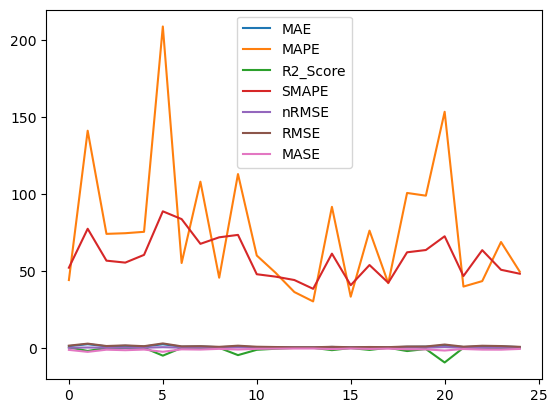

In [160]:
validation_metrics.plot()

In [156]:
validation_metrics.tail(1)

,MAE,MAPE,R2_Score,SMAPE,nRMSE,RMSE,MASE,start_date,end_date
24,0.583416,49.5,0.001708,48.21,0.180699,0.764323,-0.59,2023-12-17,2024-01-01


In [157]:
def sliding_window_validation_test(
        start_date="01-01-2023 00:00:00", 
        end_date="01-01-2024 00:00:00",
        window_size=14, 
        model=None, 
        data=None, 
        x_cols=None, 
        y_col=None
    ):
    data_info = pd.DataFrame()

    # training window
    t_start_date = datetime.strptime(start_date, '%d-%m-%Y %H:%M:%S').date()
    t_end_date = t_start_date + timedelta(days=window_size)
    # validation window
    v_start_date = t_end_date
    v_end_date = v_start_date + timedelta(days=window_size)

    max_date = datetime.strptime(end_date, '%d-%m-%Y %H:%M:%S').date()
    no_data = []
    progress_bar = tqdm(total=(((max_date - t_start_date).days // 7) // 2) - 1)
    while v_end_date <= max_date: # validation window will be the first to reach the end date

        # check if the last date with max date
        if v_end_date + timedelta(days=window_size) > max_date:
            v_end_date = max_date
        
        # filter data
        train_data = data[(data.index >= t_start_date.strftime("%Y-%m-%d")) & 
                          (data.index < v_start_date.strftime("%Y-%m-%d"))]
        val_data = data[(data.index >= v_start_date.strftime("%Y-%m-%d")) & 
                        (data.index < v_end_date.strftime("%Y-%m-%d"))]
        
        tmp = pd.DataFrame({
            "train_start_date": [t_start_date],
            "train_end_date": [v_start_date],
            "train_size": [train_data.shape[0]],
            "val_start_date": [v_start_date],
            "val_end_date": [v_end_date],
            "val_size": [val_data.shape[0]]
        })

        data_info = pd.concat([data_info, tmp], axis=0, ignore_index=True)

        # update the dates
        t_start_date = v_start_date
        t_end_date = v_end_date
        v_start_date = t_end_date
        v_end_date = v_start_date + timedelta(days=window_size)
        progress_bar.update(1)
    
    progress_bar.close()
    
    return data_info

In [158]:
data_info = sliding_window_validation_test(
    start_date="01-01-2023 00:00:00", 
    end_date="01-01-2024 00:00:00",
    window_size=14,
    model=model, data=main_data, x_cols=x_cols, y_col=y_cols
)

  0%|          | 0/25 [00:00<?, ?it/s]

In [159]:
data_info

,train_start_date,train_end_date,train_size,val_start_date,val_end_date,val_size
0,2023-01-01,2023-01-15,336,2023-01-15,2023-01-29,336
1,2023-01-15,2023-01-29,336,2023-01-29,2023-02-12,336
2,2023-01-29,2023-02-12,336,2023-02-12,2023-02-26,336
3,2023-02-12,2023-02-26,336,2023-02-26,2023-03-12,336
4,2023-02-26,2023-03-12,336,2023-03-12,2023-03-26,336
5,2023-03-12,2023-03-26,336,2023-03-26,2023-04-09,336
6,2023-03-26,2023-04-09,336,2023-04-09,2023-04-23,336
7,2023-04-09,2023-04-23,336,2023-04-23,2023-05-07,336
8,2023-04-23,2023-05-07,336,2023-05-07,2023-05-21,336
9,2023-05-07,2023-05-21,336,2023-05-21,2023-06-04,336


In [146]:
main_data[
    (main_data.index >= "2023-01-29") & (main_data.index < "2023-02-12")
].shape

(336, 20)

In [147]:
main_data.head()

,bld_engcons,weekend,bank_holiday,day_of_week,day_of_month,month,year,forecast_temperature,forecast_feelslike,forecast_weathertype,forecast_windspeed,forecast_uvindex,forecast_precipitationprobability,forecast_visibility,week_of_year,sine_hour,cos_hour,sine_forecast_winddirection,cos_forecast_winddirection,t-1
datetime,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,3.629499,0,1,5,1,1,2021,3.0,-1.0,2.0,11.0,0.0,0.0,5,53,0.000000,1.000000,0.000000,1.00000,4.215506
2021-01-01 01:00:00+00:00,4.215506,0,1,5,1,1,2021,3.0,-1.0,2.0,11.0,0.0,0.0,5,53,0.258819,0.965926,0.000000,1.00000,5.994066
2021-01-01 02:00:00+00:00,5.994066,0,1,5,1,1,2021,3.0,-1.0,2.0,11.0,0.0,1.0,5,53,0.500000,0.866025,0.000000,1.00000,5.954252
2021-01-01 03:00:00+00:00,5.954252,0,1,5,1,1,2021,2.0,-2.0,0.0,11.0,0.0,1.0,5,53,0.707107,0.707107,-0.382683,0.92388,5.620296
2021-01-01 04:00:00+00:00,5.620296,0,1,5,1,1,2021,2.0,-2.0,0.0,11.0,0.0,1.0,5,53,0.866025,0.500000,-0.382683,0.92388,5.750796
